In [1]:
import probnum as pn
import numpy as np
import probnum_galerkin as pn_gal
import matplotlib.pyplot as plt
import scipy.spatial

In [37]:
class ExpQuad2ndDerivKernel(pn.kernels.Kernel):
    def __init__(self, lengthscale = 1.0):
        self.lengthscale = pn.utils.as_numpy_scalar(lengthscale)
        super().__init__(input_dim=1, output_dim=1)

    def __call__(self, x0, x1 = None) -> np.ndarray:
        x0, x1, kernshape = self._check_and_reshape_inputs(x0, x1)

        x1 = x1 or x0
        
        x0 = x0[:, None, :]
        x1 = x1[None, :, :]
        
        l = self.lengthscale
        
        diff = x0 - x1
        
        kernmat = np.exp(-(1 / (2 * l ** 2)) * diff ** 2)
        kernmat *= diff ** 4 / (l ** 8) - 6 * diff ** 2 / (l ** 6) + 3 / (l ** 4)

        return pn.kernels.Kernel._reshape_kernelmatrix(kernmat, newshape=kernshape)

def expquad_cross_cov(x0, x1):

    return 

In [38]:
# Prior
lengthscale = 1.0

gp = pn.randprocs.GaussianProcess(
    mean=lambda x: -0.5 * x ** 2 + 0.5,
    cov=pn.kernels.ExpQuad(
        input_dim=1,
        lengthscale=lengthscale,
    ),
)

gp_deriv = pn.randprocs.GaussianProcess(
    mean=lambda x: 0 * x + 0.5,
    cov=ExpQuad2ndDerivKernel(
        lengthscale=lengthscale,
    ),
)

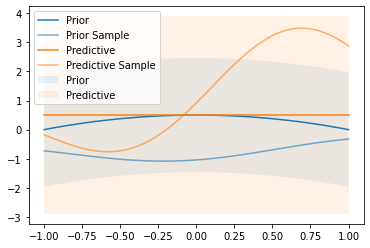

In [39]:
grid = np.linspace(-1, 1, 100)
gp.plot(plt.gca(), grid, label="Prior")
plt.plot(grid, gp.sample(np.random.default_rng(24), grid[:, None]), label="Prior Sample", c="C0", alpha=0.6)

gp_deriv.plot(plt.gca(), grid, label="Predictive")
plt.plot(grid, gp_deriv.sample(np.random.default_rng(24), grid[:, None]), label="Predictive Sample", c="C1", alpha=0.6)
plt.legend()

In [174]:
# Inference
class ExpQuadPoissonPosteriorKernel(pn.kernels.Kernel):
    def __init__(self, kernel, crosscov, gram):
        self.k = kernel
        self.K = gram
        self.crosscov = crosscov
        self.L_K = scipy.linalg.cho_factor(gram)
        self.lengthscale = kernel.lengthscale
        super().__init__(input_dim=1, output_dim=1)

    def __call__(self, x0, x1 = None) -> np.ndarray:
        x0, x1, kernshape = self._check_and_reshape_inputs(x0, x1)

        x1 = x1 or x0
        
        kernmat = self.k(x0, x1)
        kernmat -= self.crosscov(x0)[:, :, 0].T @ scipy.linalg.cho_solve(self.L_K, self.crosscov(x1)[:, :, 0])

        return pn.kernels.Kernel._reshape_kernelmatrix(kernmat, newshape=kernshape)
    
    def mean(self, m, Lm, obs, x):
        if m.ndim > 1:
            m = m[:, 0]
        return m + self.crosscov(x)[:, :, 0].T @ scipy.linalg.cho_solve(self.L_K, (obs - Lm))[:, 0]
    
def crosscov(xtrain, xtest, lengthscale):
    xtrain = xtrain[:, None, :]
    
    if xtest.ndim == 1:
        xtest = xtest[None, :, None]
    else:
        xtest = xtest[None, :, :]
    
    l = lengthscale
    
    crosscov = pn.kernels.ExpQuad(1, lengthscale)(xtrain[:, 0, :], xtest[0, :, :])[:, :, None]
    crosscov *= (xtrain - xtest) ** 2 / (l ** 4) - 1 / (l ** 2)
    
    return crosscov

In [181]:
N = 200
meas_loc = np.linspace(-0.9, 0.9, N)[:, None]
obs = meas_loc * 0 - 1.0
m = gp.mean(meas_loc)
Lm = gp_deriv.mean(meas_loc)

post_ker = ExpQuadPoissonPosteriorKernel(
    gp._covfun,
    lambda xtest: crosscov(meas_loc, xtest, lengthscale),
    gram=gp_deriv.cov(meas_loc) + 1e-6 * np.eye(N),
)

gp_post = pn.randprocs.GaussianProcess(
    mean=lambda x: post_ker.mean(gp.mean(x), Lm, obs, x),
    cov=post_ker,
)

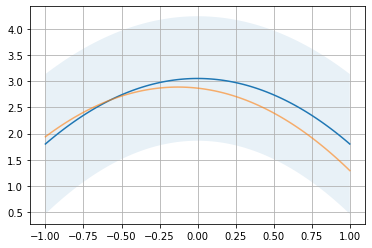

In [183]:
gp_post.plot(plt.gca(), grid)
plt.plot(grid, gp_post.sample(np.random.default_rng(42), grid[:, None]), label="Predictive Sample", c="C1", alpha=0.6)
plt.grid()